# **BeamformingBasics**
Basic delay-and-sum beamforming routines in Python for demonstration purposes

https://github.com/fchirono/BeamformingBasics

This Python package provides some basic functions for creating Uniform Linear Arrays (ULAs) and delay-and-sum beamforming using these arrays. The implementations provided herein are **not** optimized in any form, and instead are meant to be simple to follow.

### Author:
Fabio Casagrande Hirono - fchirono [at] gmail.com

April 2021


# Beamforming Tutorial

Let us use the `BeamformingBasics` package to create a Uniform Linear Array, synthesize some acoustic signals, and apply delay-and-sum beamforming to filter these signals. We begin by cloning the GitHub repo to Google Colab's virtual machine using the commands below:

In [ ]:
!git clone https://github.com/fchirono/BeamformingBasics.git

import sys sys.path.insert(0,'/content/BeamformingBasics')


Let us now import the usual Python packages for scientific programming: `numpy` for numerical computing, `matplotlib` for plotting, and our own `BeamformingBasics` (imported as `bf`):

In [7]:
# package for numeric computing
import numpy as np

# package for basic plotting
from matplotlib import pyplot as plt

# package for beamforming basics
import BeamformingBasics as bf


plt.close('all')

save_fig = False

# speed of sound
c0 = 1500.

We now define the necessary variables to create a vector `t` of time-domain samples, of duration `T` seconds and sampling frequency `fs` Hz:

In [3]:
# Create vector of time samples
fs = 48e3       # sampling freq [Hz]
dt = 1./fs      # temporal resolution [s]
T = 0.5           # length of recording [s]

N_time = int(T*fs)

# vector of time samples
t = np.linspace(0, T-dt, N_time)

To our ULA: the `BeamformingBasics` package allows us to create a ULA by calling the function `bf.SensorArray(L, M)`, where `L` is the array length in meters and `M` is the number of sensors (here we assume `M` is always odd for simplicity). Note that, upon successful creation of our ULA, the function will automatically print the inter-sensor spacing for this array:

In [4]:
# create uniform linear array - try to change these values and see what happens!

L = 1.4     # [m]
M = 15      

MyULA = bf.SensorArray(L, M)

Array inter sensor spacing is 0.09999999999999999 m


Our array definition is stored in the object `MyULA`, and its properties can be explored as shown here:

In [5]:
print(MyULA.M)    # number of elements in array
print(MyULA.L)    # array length
print(MyULA.d)    # inter-sensor spacing
print(MyULA.m)    # vector of indices (from -(M-1)/2 to +(M-1)/2, so m=0 is center element)
print(MyULA.XY)   # (2, M)-shaped array containing the (x,y) coordinates of each sensor

15
1.4
0.09999999999999999
[-7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7]
[[-0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6
   0.7]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. ]]


We will now create the source signal. We will use the function `bf.create_narrowband_pulse` to create a signal with center frequency `f0`, amplitude `a0` and duration `T_pulse`. Let us also check whether our ULA might be subject to spatial aliasing at this specific frequency!

In [8]:
# define pulse characteristics: amplitude, duration, onset time, center frequency
a0 = 1.
T_pulse = 0.002      # [s]
N_pulse = int(T_pulse*fs)

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# narrowband pulse center frequency - try other values!
f0 = 5000            # [Hz]
# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

x_pulse = bf.create_narrowband_pulse(a0, T_pulse, f0, fs)

# acoustic wavelength of pulse center freq
ac_wavelength = c0/f0

print("Acoustic wavelength for f0 = {} Hz is {} m".format(f0, ac_wavelength))

# check for spatial aliasing condition
if MyULA.d >= ac_wavelength/2:
    print('\tCareful --> Aliasing might occur!')

Acoustic wavelength for f0 = 5000 Hz is 0.3 m


Now, we need to choose one direction of arrival `theta0_deg` for our incoming plane wave containing the narrowband pulse, the onset time for the pulse, and a signal-to-noise ratio (SNR) for the array signals. In order to inspect the resulting data, let us plot the signals for the first, the middle and the last sensors in our array:

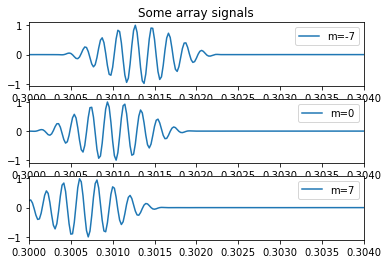

In [38]:
# create array of sensor signals from a given direction of arrival

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# direction of arrival of narrowband pulse
# --> try any value between 0 and 180
theta0_deg = 45.

# signal-to-noise ratio at array signal
# --> 60 dB means almost no noise is present;
# -->  0 dB means signal and noise have the same power - will the beamformer even work?
SNR_dB = 60
# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

# onset time of narrowband pulse
t_initial = 0.3

p_array = bf.create_array_signals(MyULA, x_pulse, t_initial, T, theta0_deg, fs,
                                  c0, SNR_dB)

# plot some array signals
plt.figure()

m_index = [0, int((M-1)/2), M-1]
for m in range(3):
    plt.subplot(3, 1, m+1)
    
    if m == 0:
        plt.title('Some array signals')
    plt.plot(t, p_array[m_index[m],:], label='m={}'.format(m_index[m]-M//2))
    plt.xlim([t_initial, t_initial+2*T_pulse])
    plt.legend()


In order to calculate the delay-and-sum beamformer, we need a vector of steering angles `theta` (i.e. "look directions") to steer our array towards. Let's define a range of `N_theta` points over the entire [0, 180deg] range. Let us also define our vector of amplitude shading `weights` - just uncomment the one you choose and comment out the others. 

The actual beamforming calculation is performed via the function `bf.delayandsum_beamformer`, which takes as arguments the object containing the array geometry, the array of sensor signals, the vector of look directions, and the sampling frequency. This function might take a few seconds to run (remember, the code is **not** optimized!). The beamformer function returns a (`N_theta`, `N_time`)-shaped array containing the beamformer output signal y(t) for each look direction theta.

In [34]:
# use delay-and-sum beamforming to map direction of arrival

N_theta = 181
theta = np.linspace(0, np.pi, N_theta)

N_DoA = int(theta0_deg)

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
## array shading schemes - uncomment one
weights = np.ones(M)
# weights = ss.windows.hann(M)
# weights = ss.windows.chebwin(M, 40)
# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

y_beamformer = bf.delayandsum_beamformer(MyULA, p_array, theta, weights, fs)

We now plot the beamformer output y(theta, t) for a few candidate steering directions. If the steering direction matches the direction of arrival `theta0` of the plane wave, you should see a large amplitude narrowband pulse; otherwise, expect to see small amplitudes - or even zero.

It is very interesting to compare the beamformer output y(t) to the signal captured by the center sensor p0(t). The second figure was created so that it superimposes the center sensor signal to the beamformer output when the steering direction matches the plane wave DoA; note how the beamformer output has significantly less noise than the single sensor!

Text(0.5, 1.0, 'Center sensor vs. beamformer output')

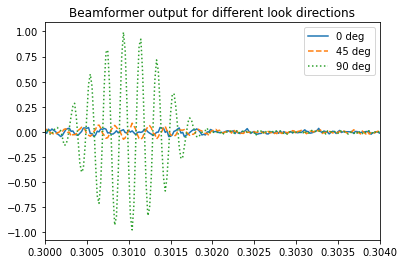

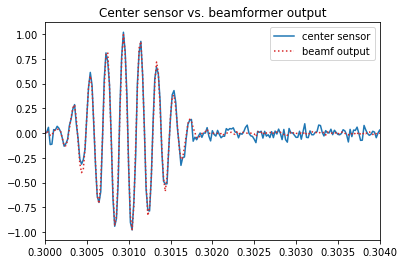

In [35]:
# plot beamformer output for different steering directions
plt.figure()
plt.plot(t, y_beamformer[0, :], label='0 deg')
plt.plot(t, y_beamformer[45, :], '--', label='45 deg')
plt.plot(t, y_beamformer[90, :], ':', label='90 deg')
plt.xlim([t_initial, t_initial+2*T_pulse])
plt.legend()
plt.title('Beamformer output for different look directions')


# compare beamformer output to center sensor signal
plt.figure()
plt.plot(t, p_array[M//2, :], label='center sensor')
plt.plot(t, y_beamformer[N_DoA, :], ':', label='beamf output', color='C3')
plt.xlim([t_initial, t_initial+2*T_pulse])
plt.legend()
plt.title('Center sensor vs. beamformer output')


Finally, let us look into the polar response of the beamformer. For convenience, we'll also indicate the plane wave direction of arrival with a red arrow.

The polar plot restricts the minimum magnitude below the peak through the variable `dyn_range`. Certain beamformer configurations can lead to the sidelobes disappearing from the image (for example, when the array shading scheme significantly reduces their amplitude), while others can lead to an almost uniform angular response, with a very small main lobe value (for example, when the SNR is low). Make sure to increase or decrease `dyn_range` accordingly.

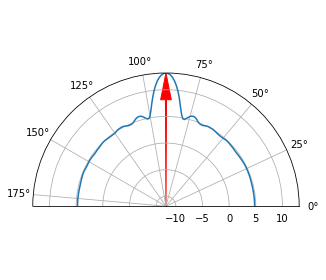

In [36]:
# beamformer polar plot

y_beamf_polar = np.sum(y_beamformer**2, axis=1)

y_beamf_polar_dB = 10*np.log10(y_beamf_polar)
dB_max = y_beamf_polar_dB.max()

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Polar plot dynamic range
dyn_range = 25      # dB
# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(theta, y_beamf_polar_dB)

# add arrow indicating direction of arrival of signal
ax.arrow(theta0_deg*np.pi/180, dB_max-dyn_range, 0, dyn_range, width=0.01,
         head_width=0.1, head_length=5,
         length_includes_head=True, edgecolor = 'red', facecolor = 'red')

ax.set_rmax(dB_max)
ax.set_rmin(dB_max - dyn_range)

ax.set_thetamin(0)
ax.set_thetamax(180)
fig.set_tight_layout(True)
